# Shoprite Data Science take home assessment

### Main Objective

1. The main task of the challange is to predict the June 2020 sales volume on a store product level, given historical data from January 2018 to May 2020

2. The secondary task is to create a store/shop segmentation using any of the available sales data (value, volume, item, etc.)

### Data and Data fields

#### Data provided
We are provided with two csv files:
1. historic_sales_data.csv - which contains daily sales data from January 2018 to May 2020 (on a day, product and store granularity) and
2. items.csv - which contains the product categories.

#### Data fields 
1. Shop_id - unique identifier for a specific shop
2. Item_id - unique identifier for a product
3. Item_category_id - unique identifier for an item category
4. Item_cnt_day - number of products sold
5. Item_price - current price of an item
6. Day - day product was purchased
7. Month - month product was purchased
8. Year - year product was purchased

## Table of contents:

### Exploratary Data Analysis

1. Load libraries
2. Load the Data
3. Basic EDA and Analysis 

### 1. Loading Libraries and data used in the Notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

from datetime import date
import holidays

%matplotlib inline

#### Loading the data

In [2]:
historic_sales = pd.read_csv('historic_sales_data.csv')
item_category = pd.read_csv('item.csv')

### 2. Basic EDA and trend analysis

In [3]:
historic_sales.head()

,day,month,year,shop_id,item_id,item_price,item_cnt_day
0,22,11,2018,52,1003734,1300,1
1,24,11,2018,52,1003734,1300,1
2,28,11,2018,52,1003734,1300,1
3,1,11,2018,52,1003743,400,1
4,20,11,2018,52,1003743,400,1


In [4]:
historic_sales.info()
historic_sales.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664552 entries, 0 to 2664551
Data columns (total 7 columns):
day             int64
month           int64
year            int64
shop_id         int64
item_id         int64
item_price      int64
item_cnt_day    int64
dtypes: int64(7)
memory usage: 142.3 MB


(2664552, 7)

In [5]:
item_category.head()

,item_id,item_category_id
0,1000000,80
1,1000001,152
2,1000002,80
3,1000003,80
4,1000004,80


In [16]:
item_category.info()
item_category.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 2 columns):
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2)
memory usage: 346.5 KB


(22170, 2)

##### create new dateframe with both tables

In [17]:
df = historic_sales.merge(item_category, on='item_id', how='left') 

In [18]:
df.head()

,day,month,year,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,22,11,2018,52,1003734,1300,1,46
1,24,11,2018,52,1003734,1300,1,46
2,28,11,2018,52,1003734,1300,1,46
3,1,11,2018,52,1003743,400,1,42
4,20,11,2018,52,1003743,400,1,42


Check for null values. There are none, phew!.

In [19]:
df.isnull().sum()

day                 0
month               0
year                0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

In [20]:
df.apply(lambda x: len(x.unique()))

day                    31
month                  12
year                    3
shop_id                59
item_id             20292
item_price           2834
item_cnt_day          187
item_category_id       83
dtype: int64

##### Notes

The dataframe contains data from 59 shops with 20 292 products belonging to 2834 product categories. The dates are in integers and we need to change them to datetime format so that we can continue with exploration

In [21]:
#Add new column with date in datetime format

df['date']=df[['day','month','year']].astype(str).apply('-'.join,1)
df['date']=pd.to_datetime(df['date'])

df = df[['day', 'month', 'year','date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id']]
df.head()

,day,month,year,date,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,22,11,2018,2018-11-22,52,1003734,1300,1,46
1,24,11,2018,2018-11-24,52,1003734,1300,1,46
2,28,11,2018,2018-11-28,52,1003734,1300,1,46
3,1,11,2018,2018-01-11,52,1003743,400,1,42
4,20,11,2018,2018-11-20,52,1003743,400,1,42


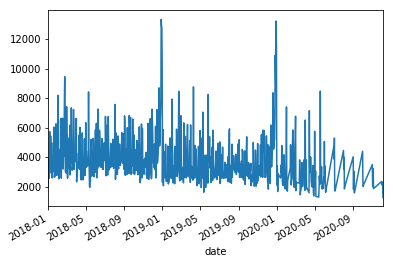

In [12]:
#Check overrall monthly sales

monthly_sales = df.groupby('date')['item_cnt_day'].sum()
monthly_sales.plot()

In [13]:
print('Min date from df set: %s' % df['date'].min().date())
print('Max date from df set: %s' % df['date'].max().date())

Min date from df set: 2018-01-01
Max date from df set: 2020-12-05


##### Notes:

The dataframe contains some data from months after May 2020, this will throw off the analysis and will need to be dealt with further as the data is inconsistent

### 2. Further EDA and feature engineering

Label data according to month by putting an index for each month

In [15]:

df['month_block']= (df['date'].dt.to_period('M').astype(int) - 
                    pd.to_datetime(['2018-01-01']).to_period('M').astype(int))

df = df[['day', 'month', 'year','date','month_block', 'shop_id', 'item_id', 
         'item_price', 'item_cnt_day', 'item_category_id']]


print(df.apply(lambda x: len(x.unique())))

df.head()

ValueError: cannot evaluate a numeric op with unequal lengths

The data contains 36 months in total, ending in December 2020. We are only interested in data until May 2020 and so all data after the 28th month will be disregarded.

In [ ]:
df = df[df['month_block']< 29]

print('Number of months in dataframe: %s' % df.month_block.max())

In [ ]:
#Check monthly sales trend again

monthly_sales = df.groupby('month_block')['item_cnt_day'].sum()
monthly_sales.plot()

In [ ]:
#Check for outliers in item price and number of items sold daily 

plt.figure(figsize=(10,4))
plt.xlim(df.item_cnt_day.min(), df.item_cnt_day.max()*1.1)
sns.boxplot(x=df.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(df.item_price.min(), df.item_price.max()*1.1)
sns.boxplot(x=df.item_price)

In [ ]:
df = df[df.item_price<100000]
df = df[df.item_cnt_day<1000]

plt.figure(figsize=(10,4))
plt.xlim(df.item_cnt_day.min(), df.item_cnt_day.max()*1.1)
sns.boxplot(x=df.item_cnt_day)


plt.figure(figsize=(10,4))
plt.xlim(df.item_price.min(), df.item_price.max()*1.1)
sns.boxplot(x=df.item_price)

In [ ]:
#Remove item with negative price

df = df[df.item_price>0]



In [ ]:
###check for the store that sold the most items

plt.figure(figsize = (19,6))

df.groupby('shop_id')['item_cnt_day'].sum().plot.bar()

In [ ]:
### Check for the highest selling product category

plt.figure(figsize = (19,6))

df.groupby('item_category_id')['item_cnt_day'].count().plot.bar()

We now add more columns to help understand the data further, this are:
1. Weekday in which the sale is taking place
2. Finding out if the day is a holiday or not
3. Revenue made by the shop from the items on that day.

In [ ]:
df['weekday']= df['date'].dt.dayofweek #0 is monday and 6 is Sunday
df['weekday'] = df['weekday']+1  #Shift days by 1 so that 1 is Monday and 7 is Sunday


zar_holidays = holidays.SouthAfrica(years={2018,2019,2020})
df['is_holiday'] = df['date'].isin(zar_holidays) #This will return a boolean 
df['is_holiday'] = df['is_holiday'].astype(int) #Change boolean to integer, True: 1 and False:0

df['sales'] = df['item_price']*df['item_cnt_day']


df = df[['day', 'month', 'year','date','month_block', 'shop_id', 'item_id', 
         'item_price', 'item_cnt_day', 'item_category_id','sales', 'weekday', 'is_holiday']]


df.head()

In [ ]:
df.info()

In [ ]:
#Check relationship between items sales and day of the week

df.groupby('weekday')['item_cnt_day'].sum().plot.bar()

#####  Notes:

There is a spike in item sales around the weekend from Thursday to Saturday, with the highest peak being on Friday.

In [ ]:
#Check highest revenue by month

plt.figure(figsize = (19,6))

df.groupby(['month'])['sales'].sum().plot.bar()

In [ ]:
###Highest grossing category

plt.figure(figsize = (19,6))

df.groupby('item_category_id')['sales'].sum().plot.bar()

In [ ]:
monthly_item_shop_sale = df.groupby(['month_block','item_id','shop_id'])['item_cnt_day'].sum()
monthly_item_shop_sale.clip(0,20).plot.hist(bins=20)

##### Notes:

The distribution of item sales grouped by month, item and shop, shows that most item-shop pairs have small monthly sale.

Add column with monthly sales count for each item in the store

In [ ]:
group = df.groupby(['month_block','shop_id', 'item_id']).agg({'item_cnt_day':['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
index_cols=['shop_id', 'item_id', 'month_block']

df = pd.merge(df,group, on=index_cols ,how='left')

df = df[['day', 'month', 'year','date','month_block', 'shop_id', 'item_id', 
         'item_price', 'item_cnt_day', 'item_category_id','sales','item_cnt_month', 'weekday', 'is_holiday']]

df.head()

In [ ]:

plt.figure(figsize=(10,4))
plt.xlim(df.item_cnt_month.min(), df.item_cnt_month.max()*1.1)
sns.boxplot(x=df.item_cnt_month)

In [ ]:
corr = df.corr()

plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
#plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

### Staff to consider next:

1. Remove shops and not showing in test and validation data but show up in training data
2. Add lag feautures to improve model
3. Add first and last sale
    

# 

In [ ]:
df1 = df.copy()
df1['date']=df1['date'].map(dt.datetime.toordinal)
df1.head()

In [ ]:
from sklearn.model_selection import train_test_split
X_train = df1.loc[df1.month_block < 27].drop(['item_cnt_month'], axis=1)
y_train = df1.loc[df1.month_block < 27]['item_cnt_month']
X_test  = df1.loc[df1.month_block == 27].drop(['item_cnt_month'], axis=1)
y_test  = df1.loc[df1.month_block == 27]['item_cnt_month']
X_valid = df1.loc[df1.month_block == 28].drop(['item_cnt_month'], axis=1)
y_valid = df1.loc[df1.month_block == 28]['item_cnt_month']

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
#XGBoost

from xgboost import XGBRegressor

model = XGBRegressor(
    max_depth=7,
    n_estimators=1000,
    min_child_weight=300,   
    colsample_bytree=0.8, 
    subsample=0.8, 
    gamma = 0.005,
    eta=0.1,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=10, 
    early_stopping_rounds = 40,
    )

#feature_imp = pd.Series(lr.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [ ]:
y_pred = model.predict(X_test)

y_pred

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

In [ ]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))